# Operationalizing LangFlow RAG evaluation with observability, governance, and experimentation.

## Overview

This notebook demonstrates how to **operationalize the evaluation of LangFlow-based RAG  applications** using **LangFuse** for observability and **IBM watsonx.governance** for metric computation, and experiment tracking.

This notebook integrates three key components to address these needs:

---

## Components and Workflow

1. **LangFlow Agent**
   - Defines an agent capable of answering Banking FAQ–type questions.
   - Dynamically decides whether to use the `search_documents` tool (Astra DB) or `calculator` based on input.
   - Uses `OpenAI GPT-4o-mini` for generating responses based on retrieved context.

#### The user sends the questions to the Agent as part of the LangFlow Playground.

2. **LangFuse Integration**
   - LangFlow runs are traced using **LangFuse**, capturing:
     - `input`, `retrieved context`, `generated output`, and timing metadata.
   - The notebook fetches these **LangFuse traces** from the last one hour and extracts them into a structured DataFrame.

3. **Dataset Preparation**
   - Adds developer-defined `ground_truth` values to enable supervised evaluation.
   - Splits the dataset into **5 test records** and **5 validation records**.

4. **Metric Evaluation**
   - Uses **IBM watsonx.governance Metrics Evaluator** to compute:
     - **Out-of-the-box metrics:**
       - `AnswerRelevanceMetric()`
       - `FaithfulnessMetric()`
       - `AnswerSimilarityMetric()`
       - `TextGradeLevelMetric()`
       - `TextReadingEaseMetric()`
     - **Custom LLMaaJ metrics:**
       - `ContextSufficiencyMetric()`
       - `ContextRelevanceMetric()`
       - `ContextPrecisionMetric()`

5. **Experiment Tracking in Evaluation Studio**
   - Creates **Test** and **Validation** experiment runs with their respective metric results.
   - Registers these runs with **Evaluation Studio** via SDK APIs.
   - Compares test and validation runs through an **AI Evaluation**, enabling quantitative comparison across iterations.

---

## Outcome

By the end of this notebook, you will:
- Have a **traceable and evaluation pipeline** for your LangFlow agents.
- See how **LangFuse** + **watsonx.governance** together enable continuous improvement of RAG systems.
- Be able to visualize performance evolution directly in the **IBM watsonx.governance Evaluation Studio** dashboard.

---

## Prerequisites

- Active LangFlow deployment with agent connected to Astra DB.
- LangFuse account with tracing enabled for LangFlow.
- % export LANGFUSE_SECRET_KEY=[LANGFUSE_SECRET_KEY]
- % export LANGFUSE_PUBLIC_KEY=[LANGFUSE_PUBLIC_KEY]
- % export LANGFUSE_HOST="https://cloud.langfuse.com"
- IBM watsonx.governance SDK configured with access credentials.

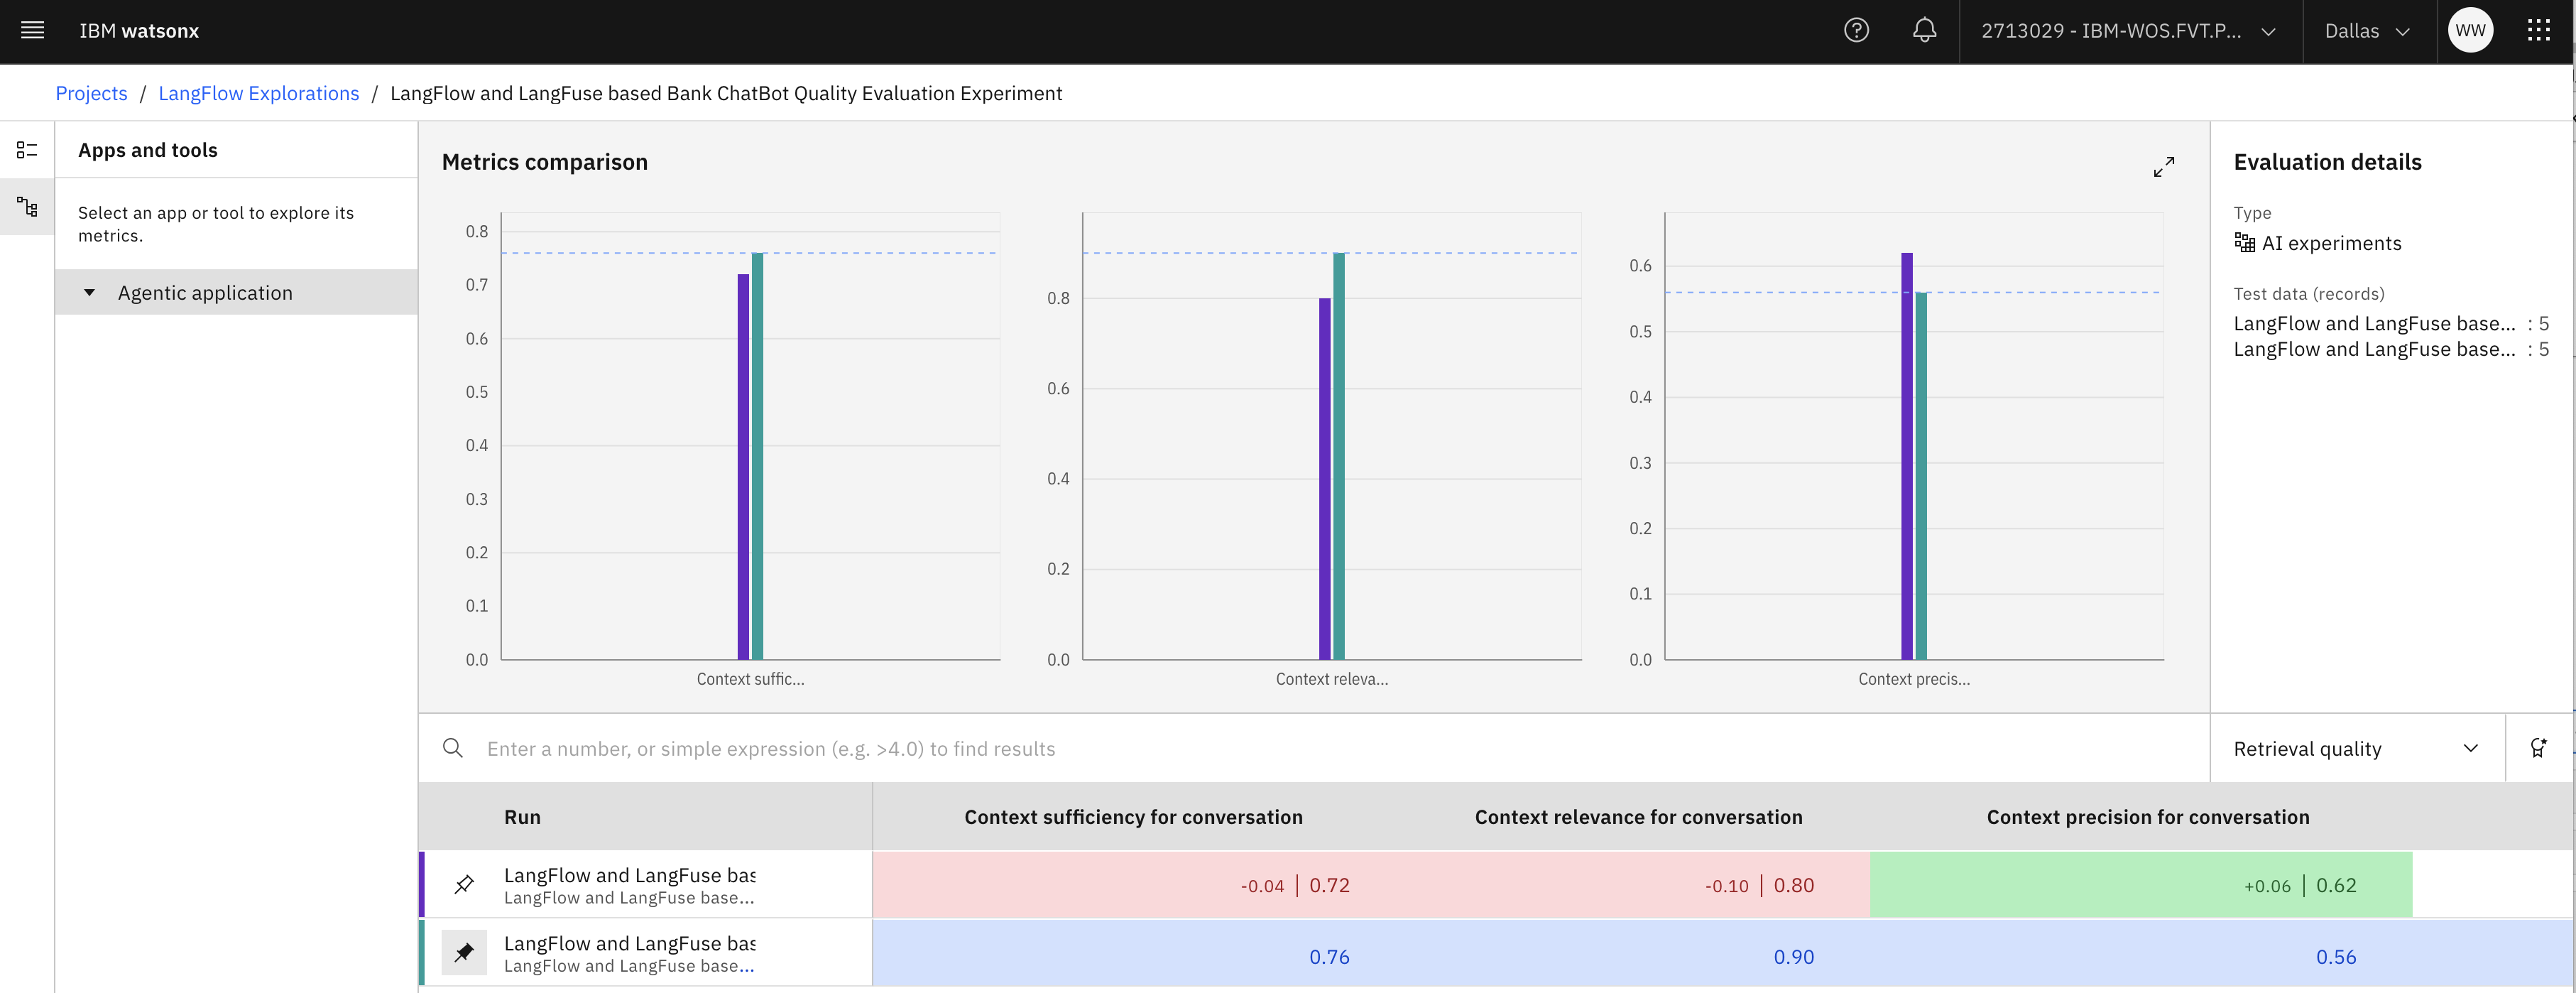

#### Required pip installations

In [ ]:
!pip install "ibm-watsonx-gov[agentic,metrics" langfuse jsonpath_ng --upgrade | tail -n 1

In [99]:
import warnings
warnings.filterwarnings("ignore")

### LangFuse and IBM watsonx.governance Credentials

In [ ]:
import os
# watsonx.governance credentials
WATSONX_APIKEY = "[Your IBM Cloud API Key]"
WATSONX_PROJECT_ID = "[Your IBM watsonx Project ID]"
WXG_SERVICE_INSTANCE_ID = '[Your IBM watsonx.governance Service Instance ID]'

# OpenAI Credentials
OPENAI_API_KEY = "[Your OpenAI API Key]"

# LangFuse Credentials
LANGFUSE_SECRET_KEY="[Your LangFuse Secret Key]"
LANGFUSE_PUBLIC_KEY="[Your LangFuse Public Key]"
LANGFUSE_HOST="https://cloud.langfuse.com"

os.environ["WATSONX_PROJECT_ID"] = WATSONX_PROJECT_ID
os.environ["WATSONX_APIKEY"] = WATSONX_APIKEY
os.environ["WATSONX_REGION"] = "us-south"
os.environ["WXG_SERVICE_INSTANCE_ID"] = WXG_SERVICE_INSTANCE_ID
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["LANGFUSE_PUBLIC_KEY"] = LANGFUSE_PUBLIC_KEY
os.environ["LANGFUSE_SECRET_KEY"] = LANGFUSE_SECRET_KEY
os.environ["LANGFUSE_HOST"] = LANGFUSE_HOST

### All imports at one place

In [15]:
from typing import List, ClassVar, Callable, Type
import pandas as pd
import numpy as np
from openai import OpenAI

from ibm_watsonx_gov.entities.credentials import Credentials
from ibm_watsonx_gov.clients.api_client import APIClient

from ibm_watsonx_gov.evaluators import MetricsEvaluator
from ibm_watsonx_gov.config import GenAIConfiguration
from ibm_watsonx_gov.metrics import *
from ibm_watsonx_gov.entities.enums import TaskType, MetricGroup
from ibm_watsonx_gov.entities.metric import GenAIMetric, MetricThreshold
from ibm_watsonx_gov.entities.evaluation_result import RecordMetricResult, AggregateMetricResult
from ibm_watsonx_gov.entities.ai_experiment import AIExperimentRun, AIExperiment
from ibm_watsonx_gov.ai_experiments.ai_experiments_client import AIExperimentsClient

#### Defining the ground truths to the questions that are sent to the LangFlow based agent

In [16]:
ground_truths = [
    {
        "question": "My beneficiary's account is not yet credited with the amount I have transferred. What do I do?",
        "ground_truth": "Please use 'raise a query' option available in the support section in the app using your \
        transaction reference number. You could also track your query from time to time."
    },
    {
        "question": "I could not find 'X' Merchant in OMP?",
        "ground_truth": "We thank you for your feedback. The existing Merchants on OPEN FINANCE platform offer wide variety \
        of products. You would find more merchants offering their products on our OMP soon."
    },
    {
        "question": "If a transaction is not credited to the beneficiary account, does the remitter get back the money?",
        "ground_truth": "Yes. If the beneficiary's bank is unable to credit the beneficiary's account for any reason, the \
        former will return the money to the remitting bank within 2 hours. Once the amount is received\
        by the remitting bank, it is credited to the remitter's account by the branch concerned."
    },
    {
        "question": "What should be done if customer does not find old transaction on the screen?",
        "ground_truth": "Please use smart search option for old transaction using date /amount/tag etc."
    },
    {
        "question": "What should be done if customer does not find transaction older than 3 years?",
        "ground_truth": "Please contact branch and put request for older transaction Or your request will be taken by us\
        and will be forwarded to our specialized team/Branch for resolution"
    },
    {
        "question": "What is the next step after raising the query?",
        "ground_truth": "Dear Customer, please select Track Query option to get the status update and reply to your query"
    },
    {
        "question": "How to track the query after it has been raised?",
        "ground_truth": "Dear Customer, you can smart search by using your details for tracking the query"
    },
    {
        "question": "I am unable to add products to my wishlist.",
        "ground_truth": "Please try adding your product again to the wishlist. If the issue persists, please mail your queries to \
        support@Openfinance.co.in."
    },
    {
        "question": "The changes I have made in my profile are not being saved.",
        "ground_truth": "User will be asked about the fields that have been modified and a query is raised to address this issue"
    },
    {
        "question": "I am unable to view the modified/changed information in my profile.",
        "ground_truth": "User will be asked about the fields that have been modified and a query is raised to address this issue"
    }    
]

## Run the agent from the LangFlow playground and send the above questions.

### Utility method to fetch the traces from LangFuse since last N hours

In [17]:
from datetime import datetime, timedelta, time, timezone
from langfuse import get_client

langfuse = get_client()

def get_traces_last_hours(hours: int = 6, limit: int = 100):
    now_utc = datetime.now(timezone.utc)
    from_ts = now_utc - timedelta(hours=hours)

    return langfuse.api.trace.list(
        limit=limit,
        from_timestamp=from_ts,
        to_timestamp=now_utc
    )

#### Extract the input, context and output from the traces

Please note that the component identifiers have to be adjusted accordingly. One can check these from one of the fetched traces.

In [18]:
def extract_trace_fields(traces):
    from jsonpath_ng import parse
    jsonpath_input = parse('$.input."Chat Input (ChatInput-qHFrs)".input_value')
    jsonpath_output = parse('$.output."Agent (Agent-Zr1RM)".response.text')
    jsonpath_context_blocks = parse('$.output."Agent (Agent-Zr1RM)".response.data.content_blocks[*].contents[*]')
    
    results = []
    for trace in traces.data:
        trace_dict = trace.dict() if hasattr(trace, "dict") else trace
    
        # Apply JSONPath queries
        user_input = [m.value for m in jsonpath_input.find(trace_dict)]
        agent_output = [m.value for m in jsonpath_output.find(trace_dict)]
    
        # Context: filter tool_use blocks named search_documents
        context_matches = [m.value for m in jsonpath_context_blocks.find(trace_dict)]
        context_texts = []
        for block in context_matches:
            if block.get("type") == "tool_use" and block.get("name") == "search_documents":
                for out in block.get("output", []):
                    text = out.get("data", {}).get("text")
                    if text:
                        context_texts.append(text)
    
        results.append({
            "id": trace_dict.get("id"),
            "input": user_input[0] if user_input else None,
            "output": agent_output[0] if agent_output else None,
            "context": "\n\n".join(context_texts) if context_texts else None
        })
    return results

### Fetch the traces

In [102]:
traces = get_traces_last_hours(hours=3, limit=100)  # last 6 hours, up to 10 traces
print(f"Got {len(traces.data)} traces")

Got 11 traces


### convert the input, context and output to a data frame

In [61]:
results = extract_trace_fields(traces)
banking_rag_chatbot_qna_ = pd.DataFrame(results)
banking_rag_chatbot_qna_

,id,input,output,context
0,4a9dd11f-9d40-4bba-8696-ab2866ee7e46,My beneficiary's account is not yet credited w...,If your beneficiary's account has not been cre...,I have transferred an amount of $XXX to a bene...
1,48e2584e-bda5-49bb-9be2-557d987789d1,I could not find 'X' Merchant in OMP?,"If you could not find 'X' Merchant in OMP, we ...",23 I could not find ‘X’ Merchant in OMP? We th...
2,a946ca2a-1604-40b2-a457-274c3929cd33,If a transaction is not credited to the benefi...,Yes. If the beneficiary's bank is unable to cr...,Yes. If the beneficiary's bank is unable to cr...
3,8f7cf9ae-6792-4f39-9761-04b3a4cd324a,What should be done if customer does not find ...,If a customer does not find an old transaction...,Yes. If the beneficiary's bank is unable to cr...
4,475ee4a6-f6b7-4cc8-8b44-209edea78454,What should be done if customer does not find ...,If a customer does not find a transaction olde...,6 What should be done if customer does not fin...
5,e34491af-cab9-4771-a607-42b1e810a37b,What is the next step after raising the query?,"After raising the query, the next step is to s...",6 What should be done if customer does not fin...
6,1400047c-e107-4e8a-8c9b-460257b8a446,How to track the query after it has been raised?,"To track your query after it has been raised, ...",8 How to track the query after it has been rai...
7,06d49713-c173-4829-b195-d3af8eb732a0,I am unable to add products to my wishlist.,If you are unable to add products to your wish...,23 I could not find ‘X’ Merchant in OMP? We th...
8,482ffbe2-6a2a-41f2-99cb-b5795f66df8b,The changes I have made in my profile are not ...,If the changes you have made in your profile a...,11 I am not able to upload my image. To be dis...
9,36e7501c-ecbd-434d-a4dc-cbfa459e158a,I am unable to view the modified/changed infor...,If you are unable to view the modified or chan...,11 I am not able to upload my image. To be dis...


In [62]:
# Drop rows where any of input, output, or context are None (or NaN)
banking_rag_chatbot_qna = banking_rag_chatbot_qna.dropna(subset=['input', 'output', 'context'])

#### Match the question and add the ground truth from the above list to the data frame

In [65]:
gt_map = {item["question"]: item["ground_truth"] for item in ground_truths}
banking_rag_chatbot_qna["ground_truth"] = banking_rag_chatbot_qna["input"].map(gt_map)
banking_rag_chatbot_qna

,id,input,output,context,ground_truth
0,4a9dd11f-9d40-4bba-8696-ab2866ee7e46,My beneficiary's account is not yet credited w...,If your beneficiary's account has not been cre...,I have transferred an amount of $XXX to a bene...,Please use 'raise a query' option available in...
1,48e2584e-bda5-49bb-9be2-557d987789d1,I could not find 'X' Merchant in OMP?,"If you could not find 'X' Merchant in OMP, we ...",23 I could not find ‘X’ Merchant in OMP? We th...,We thank you for your feedback. The existing M...
2,a946ca2a-1604-40b2-a457-274c3929cd33,If a transaction is not credited to the benefi...,Yes. If the beneficiary's bank is unable to cr...,Yes. If the beneficiary's bank is unable to cr...,Yes. If the beneficiary's bank is unable to cr...
3,8f7cf9ae-6792-4f39-9761-04b3a4cd324a,What should be done if customer does not find ...,If a customer does not find an old transaction...,Yes. If the beneficiary's bank is unable to cr...,Please use smart search option for old transac...
4,475ee4a6-f6b7-4cc8-8b44-209edea78454,What should be done if customer does not find ...,If a customer does not find a transaction olde...,6 What should be done if customer does not fin...,Please contact branch and put request for olde...
5,e34491af-cab9-4771-a607-42b1e810a37b,What is the next step after raising the query?,"After raising the query, the next step is to s...",6 What should be done if customer does not fin...,"Dear Customer, please select Track Query optio..."
6,1400047c-e107-4e8a-8c9b-460257b8a446,How to track the query after it has been raised?,"To track your query after it has been raised, ...",8 How to track the query after it has been rai...,"Dear Customer, you can smart search by using y..."
7,06d49713-c173-4829-b195-d3af8eb732a0,I am unable to add products to my wishlist.,If you are unable to add products to your wish...,23 I could not find ‘X’ Merchant in OMP? We th...,Please try adding your product again to the wi...
8,482ffbe2-6a2a-41f2-99cb-b5795f66df8b,The changes I have made in my profile are not ...,If the changes you have made in your profile a...,11 I am not able to upload my image. To be dis...,User will be asked about the fields that have ...
9,36e7501c-ecbd-434d-a4dc-cbfa459e158a,I am unable to view the modified/changed infor...,If you are unable to view the modified or chan...,11 I am not able to upload my image. To be dis...,User will be asked about the fields that have ...


### Save the content to a csv, for any future usage

In [66]:
banking_rag_chatbot_qna.to_csv("banking_rag_chatbot_agent_responses.csv", index=False)

In [67]:
# Read CSV into DataFrame
import pandas as pd
banking_rag_chatbot_qna_ = pd.read_csv('banking_rag_chatbot_agent_responses.csv')

### Sent 10 questions - where the first 5 questions are test data and remaining 5 are validation data

In [69]:
# First 5 rows
banking_rag_chatbot_qna_1 = banking_rag_chatbot_qna_.iloc[:5].reset_index(drop=True)

# Remaining 5 rows
banking_rag_chatbot_qna_2 = banking_rag_chatbot_qna_.iloc[5:].reset_index(drop=True)

## IBM watsonx.governance evaluation Starts

### Configurations

* Define the GenAIConfiguration, specifying which fields represent the question, context, the response, and the grount truth
    
* Configure the use of RAG evaluation metrics, which require the input question, retrieved context, generated response, and the ground truth answer. (Note: Only a subset of available metrics is shown here. For the complete list, refer to the watsonx.governance documentation - https://ibm.github.io/ibm-watsonx-gov/index.html)



In [72]:
credentials = Credentials(api_key=WATSONX_APIKEY,
                          service_instance_id=WXG_SERVICE_INSTANCE_ID)

# Initializing APIClient
api_client = APIClient(credentials=credentials)

### Evaluate the Metrics

* Create MetricsEvaluator
* Evaluate the metrics against the data produced from the underlying prompt or Agent

In [73]:
evaluator = MetricsEvaluator(
    api_client = APIClient(credentials=credentials),
    configuration = GenAIConfiguration(
        input_fields=["input"],
        context_fields=["context"],
        output_fields=["output"],
        reference_fields=["ground_truth"]),
)

## Defining Custom LLMaaJ metrics

- Context Sufficiency - indicating how sufficient this context is for answering the question
- Context Relevance - indicating how relevant the context is to the question
- Context Precision - indicating how precise and focused the context is
 

#### Using OpenAI gpt-4o-mini as the grader LLM

In [74]:
from openai import OpenAI
client = OpenAI()

#### Evaluate Grader Prompt against the Grader LLM

In [75]:
def evaluate_context_metric(prompt):
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": "You are a strict evaluator. Only provide a numeric score between 0 and 1 with up to 4 decimal places."},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )
    score = float(response.choices[0].message.content.strip())
    return score    

### Evaluate Context Sufficiency

In [76]:
def evaluate_context_sufficiency(question, context):
    prompt_template = """
    Question: {question}
    
    Context: {context}
    
    
    Provide a score between 0 and 1 (0=insufficient, 1=fully sufficient) indicating how sufficient this context is for answering the question. Return only the score.
    """
    prompt = prompt_template.format(question=question, context=context)
    score = evaluate_context_metric(prompt)
    return score

### Evaluate Context Relevance

In [77]:
def evaluate_context_relevance(question, context):
    prompt_template = """
    Question: {question}
    
    Context: {context}
    
    
    Provide a score between 0 and 1 (0=irrelevant, 1=highly relevant) indicating how relevant the context is to the question. Return only the score.
    """
    prompt = prompt_template.format(question=question, context=context)
    score = evaluate_context_metric(prompt)
    return score

### Evaluate Context Precision

In [78]:
def evaluate_context_precision(question, context):
    prompt_template = """
    Question: {question}
    
    Context: {context}
    
    
    Provide a score between 0 and 1 (0=not precise, 1=very precise and focused) indicating how precise and focused the context is. Return only the score.
    """
    prompt = prompt_template.format(question=question, context=context)
    score = evaluate_context_metric(prompt)
    return score

### Define the result objects for the custom LLMaaJ metrics

In [79]:
class ContextSufficiencyResult(RecordMetricResult):
    name: str = "context_sufficiency"
    display_name: str = "Context Sufficiency"
    group: MetricGroup = MetricGroup.RETRIEVAL_QUALITY

class ContextRelevanceResult(RecordMetricResult):
    name: str = "context_relevance"
    display_name: str = "Context Relevance"
    group: MetricGroup = MetricGroup.RETRIEVAL_QUALITY   

class ContextPrecisionResult(RecordMetricResult):
    name: str = "context_precision"
    display_name: str = "Context Precision"
    group: MetricGroup = MetricGroup.RETRIEVAL_QUALITY       

### Define the base context based evaluation metric. This method does the following:
- For each of records - comprising of input, context, output, and ground_truth - call the respective eval function for each of the metric.
- Construct the record level metrics
- Construct the AggregateMetricResult with the mean of all_scores, and return back the same

In [80]:
class BaseContextMetric(GenAIMetric):
    # metadata (not model fields)
    name: ClassVar[str]
    display_name: ClassVar[str]
    metric_type: ClassVar[str]
    tasks: ClassVar[List[TaskType]] = [TaskType.RAG, TaskType.GENERATION]
    group: ClassVar[MetricGroup] = MetricGroup.RETRIEVAL_QUALITY
    thresholds: ClassVar[List[MetricThreshold]] = [MetricThreshold(type="lower_limit", value=0.8)]

    # function + result class (must be marked ClassVar!)
    eval_fn: ClassVar[Callable[[str, str], float]]
    result_cls: ClassVar[Type[RecordMetricResult]]

    def evaluate(self, data, configuration, **kwargs):
        input_fields = data[configuration.input_fields[0]].to_list()
        context_fields = data[configuration.context_fields[0]].to_list()
        record_ids = data[configuration.record_id_field].to_list()

        all_scores = [self.eval_fn(q, c) for q, c in zip(input_fields, context_fields)]

        record_level_metrics = [
            self.result_cls(record_id=record_id, value=score, thresholds=self.thresholds)
            for score, record_id in zip(all_scores, record_ids)
        ]

        return AggregateMetricResult(
            name=self.name,
            display_name=self.display_name,
            group=self.group,
            value=float(np.mean(all_scores)),
            total_records=len(record_level_metrics),
            record_level_metrics=record_level_metrics,
            thresholds=self.thresholds,
        )

### Custom LLMaaJ metrics definitions

In [81]:
class ContextSufficiencyMetric(BaseContextMetric):
    name: ClassVar[str] = "context_sufficiency"
    display_name: ClassVar[str] = "Context Sufficiency"
    metric_type: ClassVar[str] = "sufficiency"
    eval_fn: ClassVar[Callable[[str, str], float]] = staticmethod(evaluate_context_sufficiency)
    result_cls: ClassVar[Type[RecordMetricResult]] = ContextSufficiencyResult


class ContextRelevanceMetric(BaseContextMetric):
    name: ClassVar[str] = "context_relevance"
    display_name: ClassVar[str] = "Context Relevance"
    metric_type: ClassVar[str] = "relevance"
    eval_fn: ClassVar[Callable[[str, str], float]] = staticmethod(evaluate_context_relevance)
    result_cls: ClassVar[Type[RecordMetricResult]] = ContextRelevanceResult


class ContextPrecisionMetric(BaseContextMetric):
    name: ClassVar[str] = "context_precision"
    display_name: ClassVar[str] = "Context Precision"
    metric_type: ClassVar[str] = "precision"
    eval_fn: ClassVar[Callable[[str, str], float]] = staticmethod(evaluate_context_precision)
    result_cls: ClassVar[Type[RecordMetricResult]] = ContextPrecisionResult

### Evaluate the OOTB and also Custom LLMaaJ metrics - on test data

In [83]:
evaluation_results_1 = evaluator.evaluate(
    data=banking_rag_chatbot_qna_1,
    metrics=[
        ContextSufficiencyMetric(), ContextRelevanceMetric(), ContextPrecisionMetric(),
        AnswerRelevanceMetric(), FaithfulnessMetric(),
        AnswerSimilarityMetric(), TextGradeLevelMetric(), TextReadingEaseMetric()
    ]
)
evaluation_results_df_1 = evaluation_results_1.to_df()
evaluation_results_df_1

[0.6, 0.5, 0.8, 0.6, 0.6]


,context_sufficiency,context_relevance,context_precision,answer_relevance.token_recall,faithfulness.token_k_precision,answer_similarity.token_recall,text_grade_level.flesch_kincaid_grade,text_reading_ease.flesch_reading_ease
0,0.8,0.8,0.6,0.500000,0.739726,0.230769,9.410823,51.042985
1,0.6,0.8,0.5,0.875000,0.947368,0.965517,6.720488,71.221870
2,1.0,1.0,0.8,0.461538,1.000000,0.974359,13.436667,41.475000
3,0.6,0.6,0.6,0.846154,0.894737,0.833333,11.165507,55.976957
4,0.6,0.8,0.6,0.857143,0.868421,0.740741,11.016111,56.157500


### Evaluate the OOTB and also Custom LLMaaJ metrics - on validation data

In [84]:
evaluation_results_2 = evaluator.evaluate(
    data=banking_rag_chatbot_qna_2,
    metrics=[
        ContextSufficiencyMetric(), ContextRelevanceMetric(), ContextPrecisionMetric(),
        AnswerRelevanceMetric(), FaithfulnessMetric(),
        AnswerSimilarityMetric(), TextGradeLevelMetric(), TextReadingEaseMetric()
    ]
)
evaluation_results_df_2 = evaluation_results_2.to_df()
evaluation_results_df_2

,context_sufficiency,context_relevance,context_precision,answer_relevance.token_recall,faithfulness.token_k_precision,answer_similarity.token_recall,text_grade_level.flesch_kincaid_grade,text_reading_ease.flesch_reading_ease
0,1.0,1.0,0.8,0.857143,1.000000,0.812500,10.486667,62.625000
1,0.8,0.8,0.6,0.888889,0.944444,0.846154,8.656026,67.734808
2,0.6,0.8,0.3,0.666667,0.892857,0.941176,7.304138,59.912989
3,0.6,0.9,0.5,0.818182,0.935484,0.888889,12.593529,65.330882
4,0.8,1.0,0.6,0.600000,0.937500,0.888889,14.580000,52.870000


In [ ]:
### Save the evaluated metrics to a csv file for future usages

In [85]:
evaluation_results_df_1.to_csv('evaluation_results_df_1.csv')
evaluation_results_df_2.to_csv('evaluation_results_df_2.csv')

#### Utility method to average the individual record level metrics, and construct the Experiment Run object

In [87]:
evaluation_results_df_1 = pd.read_csv('evaluation_results_df_1.csv')
evaluation_results_df_2 = pd.read_csv('evaluation_results_df_2.csv')

In [88]:
def construct_run_metrics(df):
    import pandas as pd
    
    # Define column mapping and grouping
    metric_mapping = {
        'context_sufficiency': ('context_sufficiency', 'retrieval_quality'),
        'context_relevance': ('context_relevance', 'retrieval_quality'),
        'context_precision': ('context_precision', 'retrieval_quality'),
        'answer_similarity.token_recall': ('answer_similarity', 'answer_quality'),
        'answer_relevance.granite_guardian': ('answer_relevance', 'answer_quality'),
        'answer_relevance.token_recall' : ('answer_relevance', 'answer_quality'),
        'faithfulness.granite_guardian' : ('faithfulness', 'answer_quality'),
        'faithfulness.token_k_precision' : ('faithfulness', 'answer_quality'),
        'text_grade_level.flesch_kincaid_grade': ('text_grade_level', 'readability'),
        'text_reading_ease.flesch_reading_ease': ('text_reading_ease', 'readability')
    }
    
    # Aggregate and build JSON list
    run_metric_results = []
    for col, (new_name, group) in metric_mapping.items():
        if col in df.columns:
            avg_value = df[col].mean()
            count = df[col].count()
            run_metric_results.append({
                "name": new_name,
                "value": round(avg_value, 4),
                "group": group,
                "count": int(count)
            })

    agent_quality_monitor_results = {
        "AgentQualityMonitor": run_metric_results
    }

    return agent_quality_monitor_results

### Test Data Run metrics

In [103]:
run_1_metric_results = construct_run_metrics(evaluation_results_df_1)

### Validation Data Run Metrics

In [104]:
run_2_metric_results = construct_run_metrics(evaluation_results_df_2)

## Creating AI Experiment asset to capture Metrics Evaluation Runs

In [91]:
# Creating AI Experiment asset
name = "LangFlow and LangFuse based Banking ChatBot AI Experiment"
description = "Evaluation of a LangFlow and LangFuse based RAG-based chatbot for common banking queries, using manually curated test cases across account services, loans, cards, digital banking, and UPI. Each case includes the user question, retrieved context, model answer, and human-verified ground truth for quality benchmarking."

ai_experiment_client = AIExperimentsClient(api_client=api_client, project_id=WATSONX_PROJECT_ID)
ai_experiment = AIExperiment(name=name, 
                             description=description,
                             component_type="agent",
                             component_name="LangFlow and LangFuse based Banking Chatbot Agent")

ai_experiment_asset = ai_experiment_client.create(ai_experiment)
ai_experiment_id = ai_experiment_asset.asset_id

Created AI experiment asset with id 62a2f01d-a9b6-4220-8a6f-03fea680ad5d.



## Create the Experiment Run for the Test Data

In [92]:
import uuid
experiment_run_1_details = AIExperimentRun(
                            run_id=str(uuid.uuid4()),
                            run_name="LangFlow and LangFuse based ChatBot Test Data Metrics Evaluation",
                            nodes=[],
                            duration=10,
                            custom_tags=[]
                        )
experiment_run_1_details

AIExperimentRun(run_id='e1f30f08-3b87-4839-a18a-bb79cf65599c', run_name='LangFlow and LangFuse based ChatBot Test Data Metrics Evaluation', created_at='', created_by='', test_data={}, tracked=False, id_deleted=False, attachment_id='', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={}, agent_method_name='')

## Associate the Test Data Run metrics with the experiment

In [93]:
ai_experiment_client.update(
    ai_experiment_id=ai_experiment_id,
    experiment_run_details=experiment_run_1_details,
    evaluation_results=run_1_metric_results
)


Storing evaluation result for experiment run e1f30f08-3b87-4839-a18a-bb79cf65599c of AI experiment 62a2f01d-a9b6-4220-8a6f-03fea680ad5d.

Creating attachment for asset 62a2f01d-a9b6-4220-8a6f-03fea680ad5d.

Successfully created attachment 0cf68245-8e51-442c-877f-db4fb838103a for asset 62a2f01d-a9b6-4220-8a6f-03fea680ad5d. Time taken: 3.631174087524414.

Updated experiment run details for run LangFlow and LangFuse based ChatBot Test Data Metrics Evaluation of AI experiment 62a2f01d-a9b6-4220-8a6f-03fea680ad5d.

Updated AI experiment asset 62a2f01d-a9b6-4220-8a6f-03fea680ad5d.



AIExperiment(container_id='', container_type='', container_name='', name='AI Experiment for Agent', description='', asset_type='', created_at='', owner_id='', asset_id='', creator_id='', component_id='', component_type='agent', component_name='LangFlow and LangFuse based Banking Chatbot Agent', runs=[AIExperimentRun(run_id='e1f30f08-3b87-4839-a18a-bb79cf65599c', run_name='LangFlow and LangFuse based ChatBot Test Data Metrics Evaluation', created_at='2025-10-05T12:14:52Z', created_by='IBMid-550002SR1C', test_data={'total_rows': 5}, tracked=False, id_deleted=False, attachment_id='0cf68245-8e51-442c-877f-db4fb838103a', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={}, agent_method_name='')])

## Create the Experiment Run for the Validation Data

In [94]:
import uuid
experiment_run_2_details = AIExperimentRun(
                            run_id=str(uuid.uuid4()),
                            run_name="LangFlow and LangFuse based ChatBot Validation Data Metrics Evaluation",
                            nodes=[],
                            duration=10
                        )
experiment_run_2_details

AIExperimentRun(run_id='75d27317-e555-42a5-b264-834a37506dc9', run_name='LangFlow and LangFuse based ChatBot Validation Data Metrics Evaluation', created_at='', created_by='', test_data={}, tracked=False, id_deleted=False, attachment_id='', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={}, agent_method_name='')

## Associate the Validation Data Run metrics with the experiment

In [95]:
ai_experiment_client.update(
    ai_experiment_id=ai_experiment_id,
    experiment_run_details=experiment_run_2_details,
    evaluation_results=run_2_metric_results
)


Storing evaluation result for experiment run 75d27317-e555-42a5-b264-834a37506dc9 of AI experiment 62a2f01d-a9b6-4220-8a6f-03fea680ad5d.

Creating attachment for asset 62a2f01d-a9b6-4220-8a6f-03fea680ad5d.

Successfully created attachment 0a2e30bd-9557-42d8-8c40-760385dd3bef for asset 62a2f01d-a9b6-4220-8a6f-03fea680ad5d. Time taken: 3.2936289310455322.

Updated experiment run details for run LangFlow and LangFuse based ChatBot Validation Data Metrics Evaluation of AI experiment 62a2f01d-a9b6-4220-8a6f-03fea680ad5d.

Updated AI experiment asset 62a2f01d-a9b6-4220-8a6f-03fea680ad5d.



AIExperiment(container_id='', container_type='', container_name='', name='AI Experiment for Agent', description='', asset_type='', created_at='', owner_id='', asset_id='', creator_id='', component_id='', component_type='agent', component_name='LangFlow and LangFuse based Banking Chatbot Agent', runs=[AIExperimentRun(run_id='e1f30f08-3b87-4839-a18a-bb79cf65599c', run_name='LangFlow and LangFuse based ChatBot Test Data Metrics Evaluation', created_at='2025-10-05T12:14:52Z', created_by='IBMid-550002SR1C', test_data={'total_rows': 5}, tracked=False, id_deleted=False, attachment_id='0cf68245-8e51-442c-877f-db4fb838103a', nodes=[], description='', source_name='', source_url='', duration=10, custom_tags=[], properties={}, agent_method_name=''), AIExperimentRun(run_id='75d27317-e555-42a5-b264-834a37506dc9', run_name='LangFlow and LangFuse based ChatBot Validation Data Metrics Evaluation', created_at='2025-10-05T12:15:08Z', created_by='IBMid-550002SR1C', test_data={'total_rows': 5}, tracked=Fal

## Create the AI Evaluation Asset with the experiment that would create the watsonx.governance AI Evaluation Studio assetm

In [96]:
from ibm_watsonx_gov.entities.ai_evaluation import EvaluationConfig
from ibm_watsonx_gov.entities.ai_evaluation import AIEvaluationAsset
ai_evaluation = ai_experiment_client.create_ai_evaluation_asset(    
    ai_experiment_ids=[ai_experiment_id],
    ai_evaluation_details=AIEvaluationAsset(
        name="LangFlow and LangFuse based Bank ChatBot Quality Evaluation Experiment",
        description="LangFlow and LangFuse based Bank ChatBot Quality Evaluation Experiment",
        evaluation_configuration=EvaluationConfig()
            ))

Retrieved AI experiment asset 62a2f01d-a9b6-4220-8a6f-03fea680ad5d.

Created AI Evaluation asset with id 157eb5f6-4604-4ea1-b4ed-66f9ad1678cc.


In [97]:
ai_evaluation.to_json()

{'container_id': 'e6f2109a-a22c-41cd-b69c-7fa65eb91add',
 'container_type': 'project',
 'container_name': 'LangFlow and LangFuse based Bank ChatBot Quality Evaluation Experiment',
 'name': 'LangFlow and LangFuse based Bank ChatBot Quality Evaluation Experiment',
 'description': 'LangFlow and LangFuse based Bank ChatBot Quality Evaluation Experiment',
 'asset_type': 'ai_evaluation',
 'created_at': '2025-10-05T12:15:20Z',
 'owner_id': 'IBMid-550002SR1C',
 'asset_id': '157eb5f6-4604-4ea1-b4ed-66f9ad1678cc',
 'creator_id': 'IBMid-550002SR1C',
 'asset_details': {'task_ids': [],
  'operational_space_id': 'development',
  'input_data_type': 'unstructured_text',
  'evaluation_asset_type': 'ai_experiment'},
 'evaluation_configuration': {'monitors': {'agentic_ai_quality': {'parameters': {'metrics_configuration': {}}}},
  'evaluation_assets': [{'id': '62a2f01d-a9b6-4220-8a6f-03fea680ad5d',
    'container_id': 'e6f2109a-a22c-41cd-b69c-7fa65eb91add',
    'container_type': 'project',
    'name': 'La

Use the above href link to navigate to the Evaluation Studio for this Experiment Run.

Author: ravi.chamarthy@in.ibm.com